In [26]:
import numpy as np
import pandas as pd
import os, sys
import warnings

warnings.filterwarnings('ignore')


%cd C:\emobility

C:\emobility


In [27]:
filepath = r'.\dbs\output'
file_list = os.listdir(filepath)

df_routes=[]

for file in file_list:

    if file[-4:]=='.pkl':
        print(file)
        df_route = pd.read_pickle(filepath+ f'/{file}')
        df_routes.append(df_route)

df_routes = pd.concat(df_routes, ignore_index=True)


file_0.pkl
file_1.pkl
file_10.pkl
file_11.pkl
file_12.pkl
file_13.pkl
file_14.pkl
file_15.pkl
file_16.pkl
file_17.pkl
file_18.pkl
file_19.pkl
file_2.pkl
file_20.pkl
file_21.pkl
file_22.pkl
file_23.pkl
file_24.pkl
file_25.pkl
file_26.pkl
file_27.pkl
file_28.pkl
file_29.pkl
file_3.pkl
file_4.pkl
file_5.pkl
file_6.pkl
file_7.pkl
file_8.pkl
file_9.pkl


In [28]:
# df_OTP = pd.read_csv(f'./dbs/agents/od_pairs_vg.csv')
# df_OTP1 = df_OTP[['person','act_id']]

In [29]:
# df_OTP1 = pd.merge(df_OTP1,df_routes, on=['person','act_id'],how='left' )

In [30]:
# aaa= df_OTP1['person'][df_OTP1['complete'].isna()]
# df_OTP1[['person','act_id']][df_OTP1['complete'].isna()]

In [31]:
# df_OTP[df_OTP.person.isin(aaa)]

## here

In [32]:
df_act = pd.read_csv(f'./dbs/agents/1_activity_plans.csv')


### combine the first and the last activities durations

In [33]:
person_tripnumber = df_act.groupby(['person'])['act_id'].max().reset_index()

for trip_number in range(2, max(person_tripnumber.act_id)+1):
    person_list = person_tripnumber['person'][person_tripnumber.act_id == trip_number]
    bbb = df_act['act_time'][(df_act.person.isin(person_list))&(df_act.act_id==0)]
    df_act['act_time'][(df_act.person.isin(person_list))&(df_act.act_id==trip_number)] = df_act['act_time'][(df_act.person.isin(person_list))&(df_act.act_id==trip_number)] + bbb.values



df_act = df_act.drop(df_act[df_act.act_id == 0].index, axis=0)

df_act.sort_values(by=['person','act_id'], inplace=True, ascending=True)
df_act['act_id']= df_act['act_id']-1

### 5 trips does not in the calculated routes, assign them to not complete

In [34]:
df_act = pd.merge(df_act, df_routes, on=['person','act_id'],how='left' )

df_act[df_act['cycling_speed'].isna()]

,person,act_id,deso,POINT_X,POINT_Y,act_purpose,mode,dep_time,trav_time,trav_time_min,...,distance,act_start,act_time,act_end,score,complete,total_dist,OTP_duration,cycling_speed,duration
31721,1877397,1,1480C1080,316924.5312,6.390938e+06,home,car,18.106389,01:33:22,93.366667,...,107.372189,1180,846.950000,23.999722,83.194182,NaN,NaN,NaN,NaN,NaN
72201,1954064,1,1485C1210,319934.2074,6.474406e+06,home,car,12.464167,06:49:58,409.966667,...,281.017072,1158,667.933333,23.999722,28.950837,NaN,NaN,NaN,NaN,NaN
195473,2171148,2,1441C1130,343842.8786,6.409433e+06,home,car,14.184167,04:43:57,283.950000,...,32.034581,1135,727.050000,23.999722,64.022954,NaN,NaN,NaN,NaN,NaN
311853,2335074,0,1494A0070,396152.9479,6.506626e+06,other,car,6.026944,02:04:19,124.316667,...,160.074244,486,277.583333,12.725278,57.174617,NaN,NaN,NaN,NaN,NaN
401750,4703336,2,1480C1570,321698.6101,6.397339e+06,other,car,16.268611,00:04:14,4.233333,...,2.558535,980,148.150000,18.808333,104.698807,NaN,NaN,NaN,NaN,NaN


In [35]:
df_act['complete'][df_act['complete'].isna()] = 'no'
df_act['duration'][df_act['duration'].isna()] = 0.0

## Trip replacement algorithm

### Remove agents' tours having different transportation modes than car

In [36]:
max_trip_dist = 45000
activity_time_dividing = 0.2
daily_max_trip_dist = 150000
max_increase_in_dail_travel_time = 7200


In [37]:
df_act = df_act[df_act['mode']=='car']

#it removes about 81k trips

In [38]:
df_act['trip_replacement'] = False
df_act['duration_change'] = df_act['duration'] - df_act['trav_time_min']*60
df_act['act_time_20percent'] = (df_act['act_time']*60)*activity_time_dividing


In [39]:
def trip_replacement(row):
    if row['complete']=='yes':
        if row['total_dist'] <= max_trip_dist:
            if row['duration_change'] <= row['act_time_20percent']:
                return True
            else:
                return  False
        else:
            return  False
    else:
        return  False


In [40]:
df_act['trip_replacement'] = df_act.apply(lambda row: trip_replacement(row) , axis=1)
df_act['trip_replacement'].value_counts()/len(df_act)

True     0.736063
False    0.263937
Name: trip_replacement, dtype: float64

In [41]:
person_tripnumber.rename(columns={'act_id':'total_trip_number'},inplace=True)
df_act = pd.merge(df_act, person_tripnumber, on=['person'],how='left' )


In [42]:
#tour check-in

df_act['tour_replacement'] = True
df_act.sort_values(by=['person','act_id'], inplace=True)
df_act.reset_index(inplace=True)
df_act.drop(['index'], inplace=True, axis=1)


for index, row in df_act.iterrows():
    if row['act_id']==0:
        index_start = index
        trip_replacement = []
        person = row['person']
    trip_replacement.append(row['trip_replacement'])
    if (row['act_purpose'] == 'home') & (np.prod(trip_replacement)==0):
        df_act['tour_replacement'].iloc[index_start:(index)+1]= False
        trip_replacement = []
        index_start = index+1
    elif (row['act_purpose'] == 'home') & (np.prod(trip_replacement)==1):
        trip_replacement = []
        index_start = index+1
    elif (row['act_id'] == row['total_trip_number']-1) & (np.prod(trip_replacement)==0):
        df_act['tour_replacement'].iloc[index_start:(index)+1]= False
        trip_replacement = []
        index_start = index+1
    elif (row['act_id'] == row['total_trip_number']-1) & (np.prod(trip_replacement)==1):
        trip_replacement = []
        index_start = index+1





df_act['tour_replacement'].value_counts()/len(df_act)

True     0.58082
False    0.41918
Name: tour_replacement, dtype: float64

In [43]:

#daily_max_trip_dist

daily_cycling_dist = df_act[df_act.tour_replacement== True].groupby('person')['total_dist'].sum().reset_index()
daily_cycling_dist.rename(columns={'total_dist': 'daily_cycling_dist'}, inplace=True)

df_act = pd.merge(df_act, daily_cycling_dist, on= 'person', how='left')
df_act['daily_cycling_dist'][df_act['daily_cycling_dist'].isna()] = 0.0
df_act['tour_replacement'][df_act['daily_cycling_dist']>daily_max_trip_dist] = False

df_act['tour_replacement'].value_counts()/len(df_act)


True     0.58082
False    0.41918
Name: tour_replacement, dtype: float64

In [44]:
#max_increase_in_dail_travel_time

daily_duration_change = df_act[df_act.tour_replacement== True].groupby('person')['duration_change'].sum().reset_index()
daily_duration_change.rename(columns={'duration_change': 'daily_duration_change'}, inplace=True)

df_act = pd.merge(df_act, daily_duration_change, on= 'person', how='left')
df_act['daily_duration_change'][df_act['daily_duration_change'].isna()] = 0.0
df_act['tour_replacement'][df_act['daily_duration_change']>max_increase_in_dail_travel_time]=False

df_act['tour_replacement'].value_counts()/len(df_act)


True     0.56201
False    0.43799
Name: tour_replacement, dtype: float64

### visualization

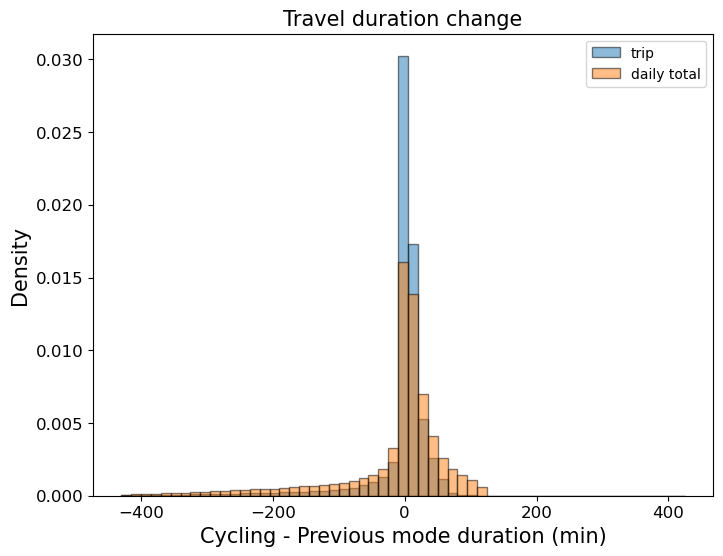

In [45]:
import matplotlib.pyplot as plt

daily_dur = df_act.drop_duplicates(subset=['person'])

plt.figure(figsize=(8,6))
plt.hist(df_act['duration_change'][df_act.tour_replacement==True]/60, density=True, bins=range(-430,430,15), alpha=0.5, align='mid', edgecolor='black', label='trip') #
plt.hist(daily_dur['daily_duration_change'][daily_dur.tour_replacement==True]/60, density=True, bins=range(-430,430,15), alpha=0.5, align='mid', edgecolor='black', label='daily total') #


plt.title('Travel duration change',fontsize=15)
plt.xlabel('Cycling - Previous mode duration (min)',fontsize=15)
plt.ylabel('Density',fontsize=15)

plt.legend(loc='upper right',fontsize=10)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()

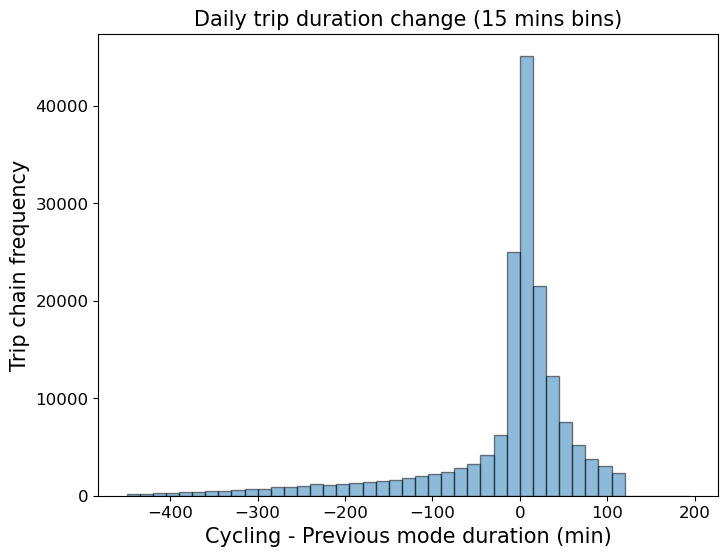

In [46]:
import matplotlib.pyplot as plt

daily_dur = df_act.drop_duplicates(subset=['person'])

plt.figure(figsize=(8,6))
#plt.hist(df_act['duration_change'][df_act.tour_replacement==True]/60, density=True, bins=range(-430,430,15), alpha=0.5, align='mid', edgecolor='black', label='trip') #
plt.hist(daily_dur['daily_duration_change'][daily_dur.tour_replacement==True]/60, density=False, bins=range(-450,200,15), alpha=0.5, align='mid', edgecolor='black')


plt.title('Daily trip duration change (15 mins bins)',fontsize=15)
plt.xlabel('Cycling - Previous mode duration (min)',fontsize=15)
plt.ylabel('Trip chain frequency',fontsize=15)

#plt.legend(loc='upper right',fontsize=10)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()

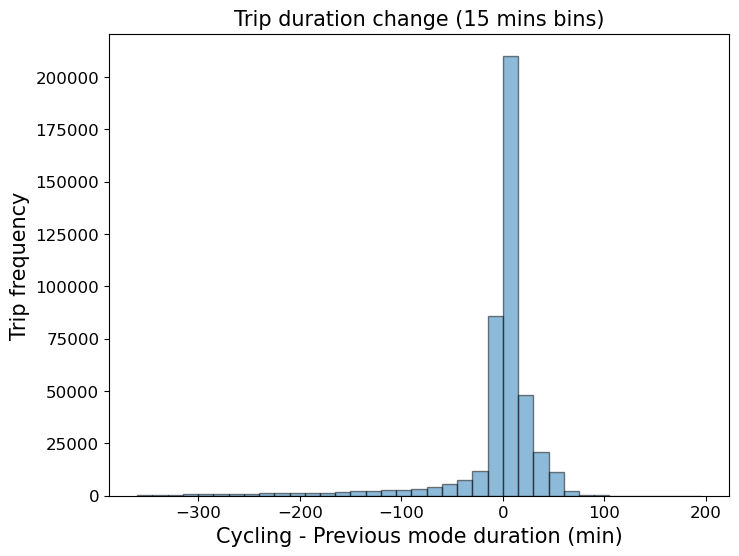

In [47]:
import matplotlib.pyplot as plt

daily_dur = df_act.drop_duplicates(subset=['person'])

plt.figure(figsize=(8,6))
plt.hist(df_act['duration_change'][df_act.tour_replacement==True]/60, density=False, bins=range(-360,200,15), alpha=0.5, align='mid', edgecolor='black') #
#plt.hist(daily_dur['daily_duration_change'][daily_dur.tour_replacement==True]/60, density=False, bins=range(-450,200,15), alpha=0.5, align='mid', edgecolor='black', label='daily total') #


plt.title('Trip duration change (15 mins bins)',fontsize=15)
plt.xlabel('Cycling - Previous mode duration (min)',fontsize=15)
plt.ylabel('Trip frequency',fontsize=15)

#plt.legend(loc='upper right',fontsize=10)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()

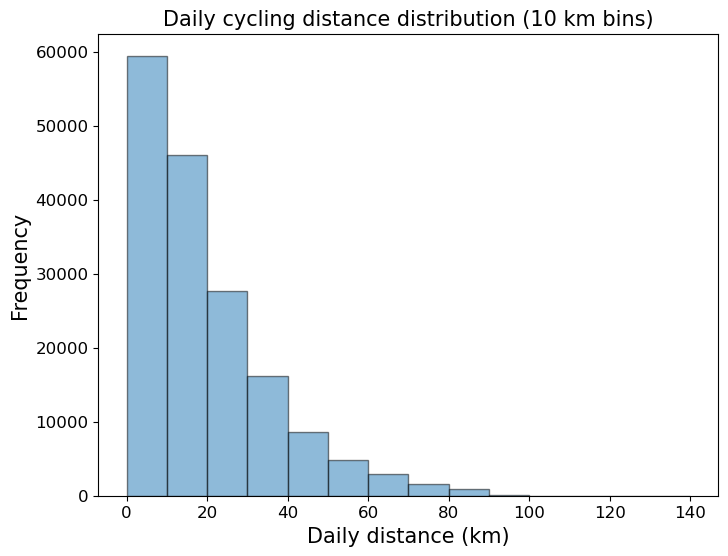

In [48]:
import matplotlib.pyplot as plt

daily_dur = df_act.drop_duplicates(subset=['person'])

plt.figure(figsize=(8,6))
plt.hist(daily_dur['daily_cycling_dist'][daily_dur.tour_replacement==True]/1000, density=False,  alpha=0.5, align='mid', edgecolor='black', bins=range(0,150,10)) #
#plt.hist(daily_dur['daily_duration_change'][daily_dur.tour_replacement==True]/60, density=False, alpha=0.5, align='mid', edgecolor='black', label='daily total') #


plt.title('Daily cycling distance distribution (10 km bins)',fontsize=15)
plt.xlabel('Daily distance (km)',fontsize=15)
plt.ylabel('Frequency',fontsize=15)

#plt.legend(loc='upper right',fontsize=10)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()

In [49]:
import geopandas as gpd
import folium
deso_path = 'C:\Synthetic_population_new\caglar\synthetic_sweden\input\deso_statistik_shp\Bef_Alder_region.shp'
gdf = gpd.read_file(deso_path)

#choose only VGR
gdf= gdf[gdf['Deso'].str[:2]=='14']

In [50]:
df_act_gdf= df_act[df_act.tour_replacement == True]
df_act_gdf1= df_act_gdf.groupby(['person'])['tour_replacement'].count().reset_index()
df_act_gdf = pd.merge(df_act_gdf[['person','deso']][df_act_gdf.act_purpose=='home'],df_act_gdf1, on='person', how='left' )

df_act_gdf= df_act_gdf.groupby(['deso'])['tour_replacement'].count().reset_index()


df_act_gdf = df_act_gdf.rename(columns={'deso':'Deso'})

gdf=gdf.merge(df_act_gdf,on="Deso")



In [156]:
# f = folium.Figure(width=800, height=500)
# m = folium.Map(location=[58, 13], zoom_start=7).add_to(f)
# folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m)
# folium.Choropleth(
#     geo_data=gdf,
#     name="choropleth",
#     data=df_act_gdf,
#     columns=['Deso','tour_replacement'],
#     key_on='feature.properties.Deso',
#     fill_color="YlGn",
#     fill_opacity=0.7,
#     line_opacity=.1,
#     #legend_name="Unemployment Rate (%)",
# ).add_to(m)


#m

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(1, 1, figsize=(16,9))

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)


gdf.plot(column='tour_replacement',
         ax=ax,
         cmap='viridis',
         legend=True,
         cax=cax,
         legend_kwds={'label': "Number of car trips replaced by e-bike ",
                        'orientation': "horizontal"})


#plt.show()
plt.savefig(r'.\figures\replaced_tripsbyDeso.jpg')